## Optimization Project 2-

Team of Analysts- <br>

Emilio Cabrera (EAC4622) <br>
Ayush Malani (AM95655) <br>
Chandler Wann (CLW4642) <br>
Chaitra Setty (CS63687) <br>


In [1]:
# Importing relevant packages

import numpy as np
import gurobipy as gp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# Reading 2019 Data

df_2019 = pd.read_csv('stocks2019.csv', index_col = 'X')
df_2019.head()

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6360.870117,46.350380,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,182.458298,...,27.590000,247.970001,147.759995,107.364159,164.080002,63.920757,159.740005,36.312473,46.041862,84.600266
2019-01-03,6147.129883,44.704514,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,179.681961,...,26.959999,243.360001,142.589996,104.083450,163.729996,63.253742,154.020004,33.835327,45.860447,81.414970
2019-01-04,6422.669922,46.488358,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,185.824142,...,28.549999,255.029999,148.970001,108.678413,172.699997,65.358139,163.350006,35.268467,46.309223,85.184715
2019-01-07,6488.250000,47.799141,229.259995,20.570000,107.940002,189.919998,1075.920044,1068.390015,1629.510010,188.324738,...,29.180000,271.000000,151.399994,108.787117,175.850006,65.733910,163.500000,36.521275,46.108707,87.434891
2019-01-08,6551.850098,49.247898,232.679993,20.750000,108.610001,192.949997,1085.369995,1076.280029,1656.579956,190.739777,...,29.480000,276.000000,156.919998,109.755516,178.190002,67.049149,166.949997,36.170105,46.643410,85.769180


In [3]:
# Reading 2020 Data

df_2020 = pd.read_csv('stocks2020.csv', index_col = 0)
df_2020.head()

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
1/2/20,8872.219727,58.266792,334.429993,49.099998,107.839996,283.679993,1368.680054,1367.369995,1898.010010,231.917572,...,36.970001,254.550003,196.729996,150.167465,219.449997,56.046688,167.460007,64.771545,60.782249,100.115349
1/3/20,8793.900391,58.286655,331.809998,48.599998,106.410004,280.440002,1361.520020,1360.660034,1874.969971,230.343124,...,36.180000,250.169998,200.880005,151.628220,217.979996,56.046688,168.440002,63.774597,61.074562,97.810677
1/6/20,8848.519531,59.349670,333.709991,48.389999,106.580002,285.880005,1397.810059,1394.209961,1902.880005,232.110748,...,35.689999,250.949997,202.740005,151.976013,224.029999,56.530506,169.490005,62.550629,60.986866,95.771927
1/7/20,8846.450195,59.945747,333.390015,48.250000,106.849998,283.059998,1395.109985,1393.339966,1906.859985,229.927765,...,37.330002,253.089996,203.210007,153.247955,223.789993,56.245903,172.949997,66.785164,60.860199,97.958405
1/8/20,8912.370117,59.488754,337.869995,47.830002,108.580002,286.000000,1405.040039,1404.319946,1891.969971,230.101654,...,36.869999,258.000000,204.149994,154.658997,231.089996,52.963551,178.710007,67.752487,60.801735,97.682640


In [4]:
# Function to pick m stocks from a dataframe of 100 stocks in the Index


def pick_stocks(df,m):

    # c: number of cols 
    c = len(df.columns)

    # This creates the dataframe of returns. Returns are calculated by taking percentage change of next day from previous day
    df = df.pct_change().dropna()
    
    # Correlation matrix
    df_corr= df.drop(columns='NDX').corr()
    
    # Objective Vector has 10100 decision variables. 
    # 10,000 decision variables for 100*100 binary values (Xij) indicating which stock j is the best representative of stock i
    # 100 binary decision variables to indicate whether or not the stock is chosen (Yj)
    vals = np.concatenate(df_corr.values)
    obj = np.array(list(vals) + [0]*len(df_corr))
        
    sense = ['='] * c + ['<'] * len(vals)
    
    
    # There will be a total of 1 + 100 + 10,000 constraints.
    # Constraint 1: Sum of Yj = m. This is so that we select just m number of best representative stocks
    # Constraints 2-101: Sum of Xij = 1 for a given value of i. This is to ensure that each stock has just 
    # one best representative
    # Constraints 102-10101: A stock should have a best representative only if that best representative is 
    # one of the m selected stocks
    
    A = np.zeros(((c+len(vals)),len(obj)))
    A[0,:][len(vals):] = 1

    # Filling constraints 2-101
    j = 0
    for i in range(1,c):
        A[i][j*(c-1):(j+1)*(c-1)] = 1
        j = j+1

    # Filling constraints 102-10101
    count = c
    for i in range(0,(c-1)):
        for j in range(0,(c-1)):
            A[count][i*(c-1)+j] = 1
            A[count][len(vals)+j] = -1
            count = count + 1
            
    b = np.array([m] + [1]*(c-1) + [0]*len(vals))

    IndexMod = gp.Model()
    IndexMod_x = IndexMod.addMVar(len(obj),vtype=['B']*len(obj)) 
    IndexMod_con = IndexMod.addMConstrs(A, IndexMod_x, sense, b)
    IndexMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

    IndexMod.Params.OutputFlag = 0 
    IndexMod.optimize()
    
    best_stocks = pd.DataFrame(zip(df_corr.columns,IndexMod_x.x[len(vals):]),columns=['stocks','selected'])
    best_stocks = best_stocks[best_stocks['selected']==1]
   
    return best_stocks

In [9]:
print("The 5 stocks selected are:")
pick_stocks(df_2019,5)

The 5 stocks selected are:


,stocks,selected
56,LBTYK,1.0
59,MXIM,1.0
63,MSFT,1.0
94,VRTX,1.0
98,XEL,1.0


In [6]:
def calculate_weights(df1, m):
    
    df1_returns = df1.pct_change().dropna()
    t = df1_returns.shape[0]
    
    # Decision Variables are the weights of the m selected stocks and the deviation of the weighted 
    # returns from the Index at a particular time period. So m weights and t time periods (m=5 and t=250 in our case)
    
    obj = np.array([0]*m + [1]*t)

    sense = ['='] + ['>']*2*t

    # There are a total of 1 + 2t constraints.
    # Constraint 1: Sum of weights of m selcted stocks = 1
    # First t constraints: The pseudo variable is greater than or equal to Index minus Weighted Returns
    # Next t constraints: The pseudo variable is greater than or equal to Weighted Returns minus Index
    
    
    A = np.zeros((1+2*t,m+t))

    # Constraint 1
    A[0,:][0:m] = 1

    best_stocks = pick_stocks(df1, m)
    
    # First t constraints
    for i in range(0,t):
        A[i+1][m+i]=1
        for j in range(0,m):
            mask = best_stocks['stocks'].iloc[j]
            A[i+1][j] = df1_returns[mask].values[i]


    # Next t constraints
    k = 0
    for i in range(250,250+t):
    
        A[i+1][m+k]=1
    
        for j in range(0,m):
            mask = best_stocks['stocks'].iloc[j]
            A[i+1][j] = -1*df1_returns[mask].values[k]
        k = k+1 
        


    b_list = [1] + list(df1_returns['NDX'].values) + list(-1*df1_returns['NDX'].values)
    
    b = np.array(b_list)
    
    IndexMod = gp.Model()
    IndexMod_x = IndexMod.addMVar(len(obj), vtype=['C']*len(obj)) 
    IndexMod_con = IndexMod.addMConstrs(A, IndexMod_x, sense, b)
    IndexMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    IndexMod.Params.OutputFlag = 0 
    IndexMod.optimize()
    
    weight_calc = pd.DataFrame(zip(best_stocks['stocks'],IndexMod_x.x[0:m]),columns = ['stocks','weights'])
        
    return weight_calc

In [8]:
print("The 5 stocks and their weights are:")
calculate_weights(df_2019, 5)

The 5 stocks and their weights are:


,stocks,weights
0,LBTYK,0.048862
1,MXIM,0.210388
2,MSFT,0.580352
3,VRTX,0.071190
4,XEL,0.089208


## Question 2

In [11]:
# This function compares the performance by using the weights from 2019 data and returns and index of 2020 data.
# The function returns the absolute deviation from the Index using weights calculated with 2019 data.

def compare_perf(df_current, df_old, m):
    ls = []
    new_df = pd.DataFrame()
    
    weights = calculate_weights(df_old, m)['weights']
    dfm_returns = df_current.pct_change().dropna()[calculate_weights(df_old, m)['stocks']]
    for i in range(m):
        new_df[i] = dfm_returns[dfm_returns.columns[i]] * weights.iloc[i]
    new_df['Sum'] = new_df.sum(axis=1)

    for j in range(len(new_df)):
        index_ret = df_current.pct_change().dropna()['NDX'][j]
        ls.append(abs(index_ret - new_df['Sum'][j]))
        
    
    return sum(ls)

In [13]:
print('The difference between 2019 Index and weighted returns of the top 5 stocks: ',round(compare_perf(df_2019,df_2019,5),4))

The difference between 2019 Index and weighted returns of the top 5 stocks:  0.7892


In [12]:
print('The difference between 2020 Index and weighted returns of the top 5 stocks: ',round(compare_perf(df_2020,df_2019,5),4))

The difference between 2020 Index and weighted returns of the top 5 stocks:  1.1124


Text(0.5, 1.0, 'Absolute Deviation of 2019 and 2020 Weighted Returns with NASDAQ-100 for m = 5')

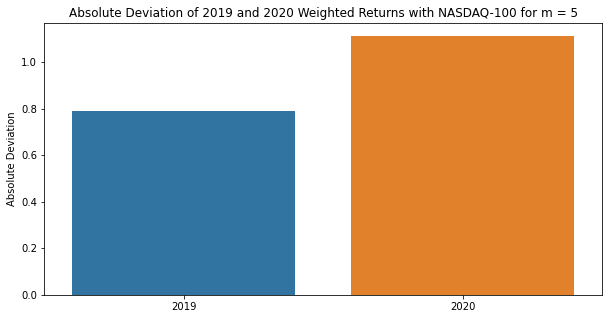

In [20]:
plt.figure(figsize=(10,5))
sns.barplot(x=['2019','2020'],y=[compare_perf(df_2019,df_2019,5),compare_perf(df_2020,df_2019,5)])
plt.ylabel('Absolute Deviation')
plt.title('Absolute Deviation of 2019 and 2020 Weighted Returns with NASDAQ-100 for m = 5')

## Question 3

In [18]:
m_list = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
perf_list_2019 = []
perf_list_2020 = []

# Comparing the Absolute Deviations over different values of stocks selected (m)

for i in m_list:
    perf_list_2019.append(compare_perf(df_2019,df_2019,int(i)))
    perf_list_2020.append(compare_perf(df_2020,df_2019,int(i)))
    
q3_df = pd.DataFrame(zip(m_list,perf_list_2019,perf_list_2020),columns=['m','2019','2020'])

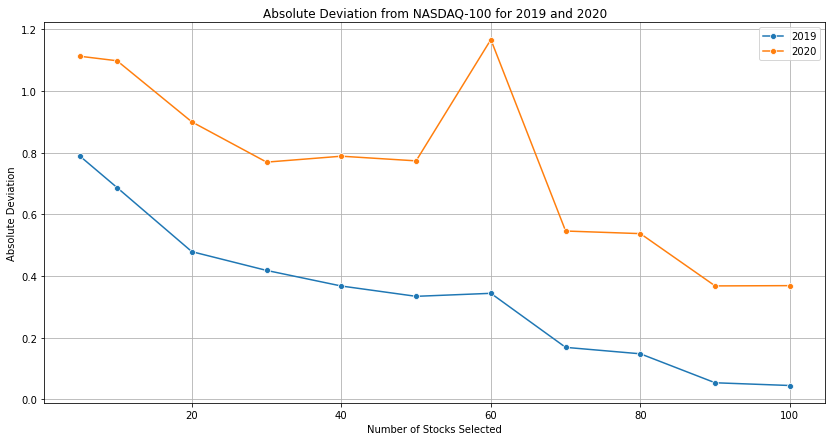

In [19]:
plt.figure(figsize = (14,7))
sns.lineplot(x=q3_df['m'],y=q3_df['2019'],label = "2019",marker = "o")
sns.lineplot(x=q3_df['m'],y=q3_df['2020'],label = "2020",marker = "o")
plt.title('Absolute Deviation from NASDAQ-100 for 2019 and 2020')
plt.xlabel("Number of Stocks Selected")
plt.ylabel("Absolute Deviation")
plt.grid()

# Question 4

In [13]:
time_limit = 3600


# This function calculates the weights by selecting all the stocks in the index to find the optimal minimum deviation
# and returns the weights of the m selected stocks. Thus, it converts the Binary and Integer Programming problem 
# into a Mixed Integer Programming problem using the big M constraint.

def all_weights(df1, m):
    n = df1.shape[1] - 1
    df1_returns = df1.pct_change().dropna()
    t = df1_returns.shape[0]
    
    # Total Decision Variables: n + n + t
    # n weights
    # n binary decision variables (whether or not stock is selected)
    # t pseudo variables for deviations over t time periods
    
    obj = np.array([0]*n + [0]*n + [1]*t)

    sense = ['=']*2 + ['<']*n + ['>']*2*t

    # Total Number of Constraints are 2 + n + 2*t
    # Constraint 1: Sum of weights = 1
    # Constraint 2: Sum of binary decision variables of whether or not the stock is selected = m
    # n constraints: The Big M constraint to limit finding a weights for a stock only if the stock is selected
    # First t constraints: The pseudo variable is greater than or equal to Index minus Weighted Returns
    # Next t constraints: The pseudo variable is greater than or equal to Weighted Returns minus Index
    
    
    A = np.zeros((2+n+2*t,2*n+t))

## Sum of weights = 1
    A[0,0:n] = 1

## Sum of y = m
    A[1,n:2*n] = 1
        
## weights - M * y
    M = 1
    
    for i in range(n):
        A[i+2][i] = 1 
        A[i+2][n+i] = -M

## Positive returns
    row = n+2
    for i in range(0,t):
        A[row][2*n+i]=1
        for j in range(0,n):
            A[row][j] = df1_returns.iloc[:,j+1].values[i]
        row += 1
    
    ## Negative returns

    for i in range(0,t):
        A[row][2*n+i]=1
        for j in range(0,n):
            A[row][j] = -1*df1_returns.iloc[:,j+1].values[i]

        row += 1
        
    b_list = [1] + [m] + [0]*n +list(df1_returns['NDX'].values) + list(-1*df1_returns['NDX'].values)
    
    b = np.array(b_list)
    
    IndexMod = gp.Model()
    IndexMod_x = IndexMod.addMVar(len(obj), vtype=['C']*n + ['B']*n + ['C']*t) 
    IndexMod_con = IndexMod.addMConstrs(A, IndexMod_x, sense, b)
    IndexMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    IndexMod.Params.OutputFlag = 0
    
    IndexMod.Params.TimeLimit = time_limit
    IndexMod.optimize()

    wt_values = IndexMod_x.x[0:n]
    yes_or_no = IndexMod_x.x[n:n+n]
        
    return wt_values, yes_or_no

In [14]:
# Calculate the absolute deviations from NASDAQ-100. 
# There might be some stocks that are selected but it is not optimal to assign a weight to them and hence their weight is 0
# 2019 weights are used to check performance on 2020 data

def new_weights_perf(df_current, df_old, m):
    

    wts, binary = all_weights(df_old,m)
    new_weights_df = pd.DataFrame(zip(df_old.drop(columns='NDX').columns,wts,binary),columns=['Stocks','Weights','Binary'])
    new_stocks_weights = new_weights_df[new_weights_df['Binary']>0]
    ls = []
    new_df = pd.DataFrame()
    
    weights = new_stocks_weights['Weights']
    dfm_returns = df_current.pct_change().dropna()[new_stocks_weights['Stocks']]
    for i in range(m):
        new_df[i] = dfm_returns[dfm_returns.columns[i]] * weights.iloc[i]
    new_df['Sum'] = new_df.sum(axis=1)

    for j in range(len(new_df)):
        index_ret = df_current.pct_change().dropna()['NDX'][j]
        ls.append(abs(index_ret - new_df['Sum'][j]))
    
    return sum(ls)


In [13]:
m_list = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

new_perf_2019 = []
new_perf_2020 = []

for i in m_list:
    new_perf_2019.append(new_weights_perf(df_2019,df_2019,int(i)))
    new_perf_2020.append(new_weights_perf(df_2020,df_2019,int(i)))
    
result_df = pd.DataFrame(zip(m_list,new_perf_2020),columns=['m','2019','2020'])

In [14]:
result_df.to_csv('final_results.csv')

## The weights for m selected stocks for 2019 and 2020 using the new method are:

In [15]:
result_df

,m,2019,2020
0,5,0.499259,0.777362
1,10,0.302576,0.637846
2,20,0.164497,0.587959
3,30,0.111569,0.530715
4,40,0.081409,0.412039
5,50,0.063542,0.412466
6,60,0.051924,0.363118
7,70,0.047958,0.363650
8,80,0.045227,0.370629
9,90,0.044911,0.368682


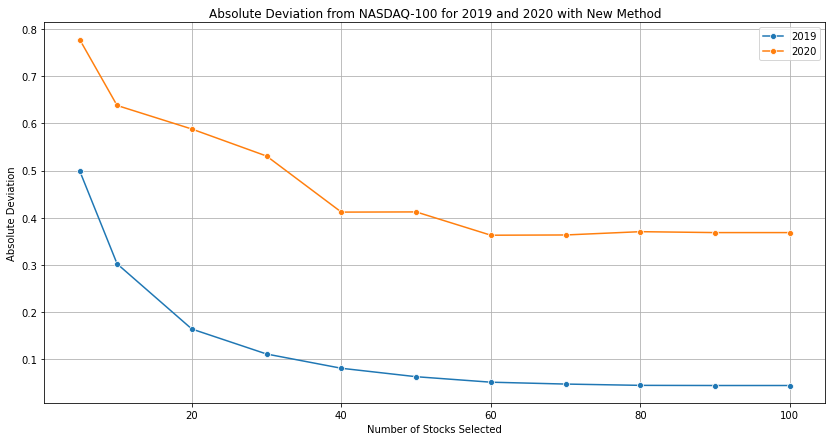

In [17]:
plt.figure(figsize = (14,7))
sns.lineplot(x=result_df['m'],y=result_df['2019'],label = "2019",marker = "o")
sns.lineplot(x=result_df['m'],y=result_df['2020'],label = "2020",marker = "o")
plt.title('Absolute Deviation from NASDAQ-100 for 2019 and 2020 with New Method')
plt.xlabel("Number of Stocks Selected")
plt.ylabel("Absolute Deviation")
plt.grid()

### Comparison of old method with new method:

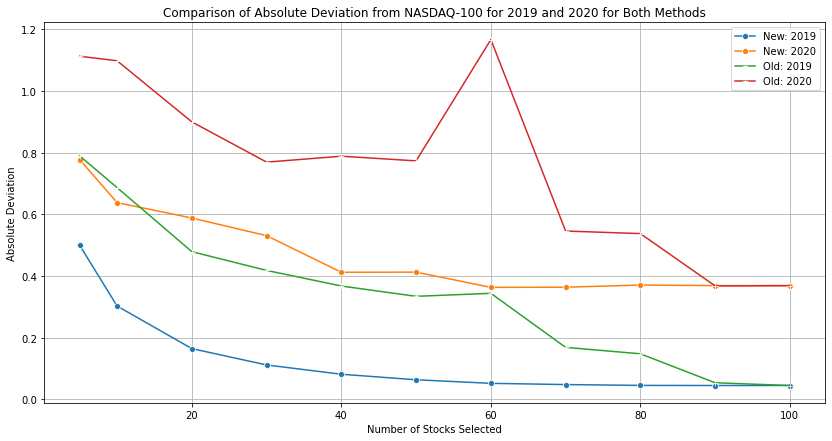

In [23]:
plt.figure(figsize = (14,7))
sns.lineplot(x=result_df['m'],y=result_df['2019'],label = "New: 2019",marker = "o")
sns.lineplot(x=result_df['m'],y=result_df['2020'],label = "New: 2020",marker = "o")
sns.lineplot(x=q3_df['m'],y=q3_df['2019'],label = "Old: 2019",marker = "+")
sns.lineplot(x=q3_df['m'],y=q3_df['2020'],label = "Old: 2020",marker = "+")

plt.title('Comparison of Absolute Deviation from NASDAQ-100 for 2019 and 2020 for Both Methods')
plt.xlabel("Number of Stocks Selected")
plt.ylabel("Absolute Deviation")
plt.grid()

It can be seen that for both 2019 and 2020, the new method performs much better than the old method for values of m ranging from 5 to 80. As expected, for values of 90 and 100, both the methods perform similarly as it means essentially using the entire index to mirror the index.